# Lab: Horse-or-Human Classifier
Learn to classify horse/human images

### Runtime
~30 minutes

### Note
Here we are dealing with real world images.  Processing them will required a lot of compute power.  
If you have access to, switch to **GPU** as run time!

### References
- https://www.tensorflow.org/tutorials/images/classification

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
print ('tensorflow version :', tf.__version__)
tf.config.experimental.list_physical_devices()

tensorflow version : 2.2.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

## TF-GPU Debug
The following block tests if TF is running on GPU.

You can monitor GPU memory usage by running 
```bash
$  nvidia-smi
# or 
$  nvidia-smi -lms  # for continous monitoring
```
on a terminal

In [2]:
## This block is to tweak TF running on GPU
## You may comment this out, if you are not using GPU

## ---- start Memory setting ----
## Ask TF not to allocate all GPU memory at once.. allocate as needed
## Without this the execution will fail with "failed to initialize algorithm" error

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



## Step 1: Download Data

Read about the data : http://www.laurencemoroney.com/horses-or-humans-dataset/

Size = 157 M

```text
    ./horse-or-human : files= 1283 , size= 157M
    ./horse-or-human/train : files= 1027 , size= 145M
    ./horse-or-human/train/humans : files= 527 , size= 72M
    ./horse-or-human/train/horses : files= 500 , size= 74M
    ./horse-or-human/validation : files= 256 , size= 12M
    ./horse-or-human/validation/humans : files= 128 , size= 5.3M
    ./horse-or-human/validation/horses : files= 128 , size= 6.3M
```


In [3]:
import os

data_location = ' https://elephantscale-public.s3.amazonaws.com/data/images/horse-or-human.zip'

data_location_local = keras.utils.get_file(fname=os.path.basename(data_location),
                                           origin=data_location, extract=True)
print ('local download file: ', data_location_local)

## Peek inside the directory
download_dir = os.path.dirname(data_location_local)
print ("download dir: ", download_dir )

# print a nice tree
! tree -d $download_dir

## if the above doesn't work, use the one below
# print ("listing of download dir: ", os.listdir(os.path.dirname(data_location_local)))

local download file:  /home/sujee/.keras/datasets/horse-or-human.zip
download dir:  /home/sujee/.keras/datasets
/home/sujee/.keras/datasets
├── cat-dog
│   └── data
│       ├── train
│       │   ├── cats
│       │   └── dogs
│       └── validation
│           ├── cats
│           └── dogs
├── cat-dog-redux
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── cats_and_dogs_filtered
│   ├── train
│   │   ├── cats
│   │   └── dogs
│   └── validation
│       ├── cats
│       └── dogs
├── cifar-10-batches-py
├── data
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── val
│       ├── cat
│       └── dog
├── flowers
│   ├── training
│   │   ├── daisy
│   │   ├── dandelion
│   │   ├── roses
│   │   ├── sunflowers
│   │   └── tulips
│   └── validation
│       ├── daisy
│       ├── dandelion
│       ├── roses
│       ├── sunflowers
│       └── tulips
└── horse-or-human
    ├── train
    │   ├── horses
    │   └── humans
    └── validation
        ├── h

In [4]:
data_dir = os.path.join(os.path.dirname(data_location_local), 'horse-or-human')

# peek inside data dir
! tree -d $data_dir

print ('local data dir: ', data_dir)
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
print ('train dir:', train_dir)
print ('validation dir:', validation_dir)

/home/sujee/.keras/datasets/horse-or-human
├── train
│   ├── horses
│   └── humans
└── validation
    ├── horses
    └── humans

6 directories
local data dir:  /home/sujee/.keras/datasets/horse-or-human
train dir: /home/sujee/.keras/datasets/horse-or-human/train
validation dir: /home/sujee/.keras/datasets/horse-or-human/validation


### See the images and get some stats

Found class lables: ['horses', 'humans']

--- training_data (/home/sujee/.keras/datasets/horse-or-human/train):  files=1027,  size=142.49 MB
       +-- horses :  files=500,  size=72.38 MB
       +-- humans :  files=527,  size=70.11 MB

--- validation_data (/home/sujee/.keras/datasets/horse-or-human/validation):  files=256,  size=10.99 MB
       +-- horses :  files=128,  size=5.98 MB
       +-- humans :  files=128,  size=5.01 MB


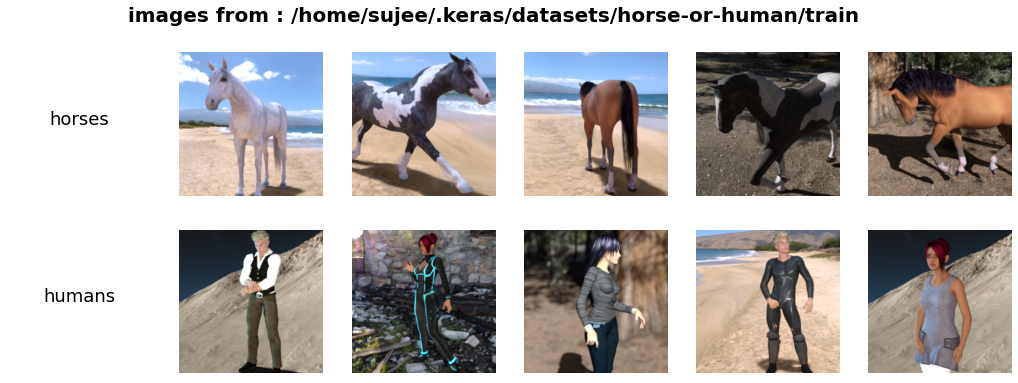

In [5]:
from image_utils import print_training_validation_stats, display_images_from_dir

print_training_validation_stats(train_dir, validation_dir)

display_images_from_dir(train_dir)

## Step 2: Define some constants

In [6]:
BATCH_SIZE=64
EPOCHS = 50
IMG_HEIGHT = 300
IMG_WIDTH = 300
APP_NAME = 'horse-human'

## Step 3: Create Image Data Generators

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Here we are rescaling images by dividing it by 255
## We are shuffling the images to increase randomness
## Images are reshaped to 150x150

# train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5,
                            brightness_range=[0.2,0.7]
                            )


## TODO-Later
## Add a train_image_generator with image augmentation


validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                            class_mode='binary'
                                                           class_mode='categorical'
                                                          )


val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                               class_mode='binary'
                                                              class_mode='categorical'
                                                             )

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Step 4: Create a Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0

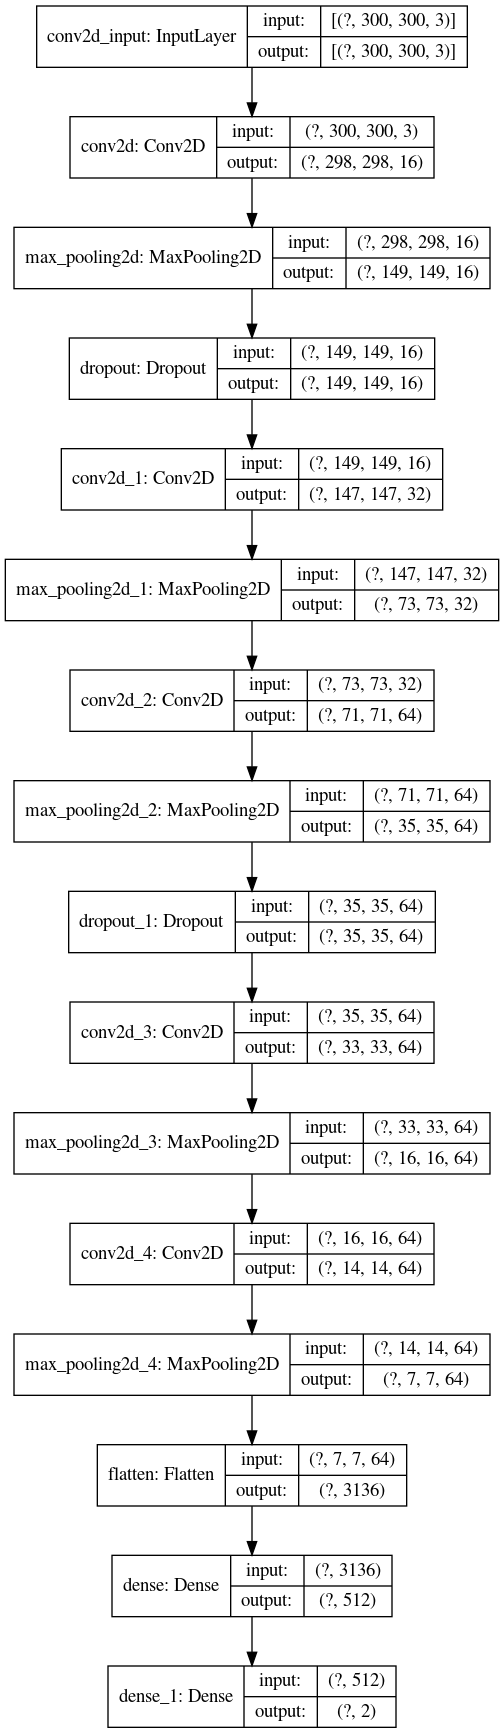

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

NUM_CLASSES = len(train_data_gen.class_indices)

model = Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    Conv2D(16, (3,3),  activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    # The second convolution
    Conv2D(32, (3,3),  activation='relu'),
    MaxPooling2D(2,2),
#     Dropout(0.3),
    # The third convolution
    Conv2D(64, (3,3),  activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.3),
    # The fourth convolution
    Conv2D(64, (3,3),  activation='relu'),
    MaxPooling2D(2,2),
#     Dropout(0.2),
    # The fifth convolution
    Conv2D(64, (3,3),  activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')  # binary
    Dense(NUM_CLASSES, activation='softmax')  # mutli-class
])



# model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
#     MaxPooling2D((2,2)),
#     Dropout(0.2),  ## <-- adding dropout
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D((2,2)),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D((2,2)),
#     Dropout(0.2),  ## <-- adding dropout
#     Flatten(),
#     Dense(512, activation='relu'),
#     #Dense(1, activation='sigmoid')
#     Dense(NUM_CLASSES, activation='softmax')
# ])

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

### Compile the model

In [9]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
              #loss='binary_crossentropy',  # for binary
              loss = 'categorical_crossentropy',  # for multi-class
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

# model.compile(optimizer='adam',
#               #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # for binary
#               loss = 'categorical_crossentropy',  # for multi-class
#               metrics=['accuracy'])

## Step 5 - Setup Tensorboard

In [10]:
## This is fairly boiler plate code

import datetime
import os
import shutil

app_name = APP_NAME


# timestamp  = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

tb_top_level_dir= '/tmp/tensorboard-logs'

tb_app_dir = os.path.join (tb_top_level_dir, app_name)

tb_logs_dir = os.path.join (tb_app_dir, datetime.datetime.now().strftime("%H-%M-%S"))


print ("Saving TB logs to : " , tb_logs_dir)

#clear out old logs
shutil.rmtree ( tb_app_dir, ignore_errors=True )

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_logs_dir, write_graph=True, 
                                                      write_images=True, histogram_freq=1)

## This will embed Tensorboard right here in jupyter!
# ! killall tensorboard  # kill previously running tensorboards
%load_ext tensorboard
%tensorboard --logdir $tb_logs_dir

Saving TB logs to :  /tmp/tensorboard-logs/horse-human/10-14-09


## Step 6 : Train

In [11]:
%%time 

from math import ceil

steps_per_epoch = train_data_gen.n // train_data_gen.batch_size
validation_steps = val_data_gen.n // val_data_gen.batch_size
print ('steps_per_epocoh:', steps_per_epoch)
print ('validation_steps:', validation_steps)

history = model.fit(
    train_data_gen,
    steps_per_epoch= steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks = [tensorboard_callback]
)

steps_per_epocoh: 16
validation_steps: 4
Epoch 1/50
16/16 [==============================] - 16s 973ms/step - loss: 0.7502 - accuracy: 0.5498 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 2/50
16/16 [==============================] - 16s 1s/step - loss: 0.7196 - accuracy: 0.6345 - val_loss: 0.7412 - val_accuracy: 0.5000
Epoch 3/50
16/16 [==============================] - 16s 985ms/step - loss: 0.6233 - accuracy: 0.6937 - val_loss: 1.9540 - val_accuracy: 0.5469
Epoch 4/50
16/16 [==============================] - 16s 978ms/step - loss: 0.6225 - accuracy: 0.6812 - val_loss: 1.1475 - val_accuracy: 0.5078
Epoch 5/50
16/16 [==============================] - 16s 972ms/step - loss: 0.5654 - accuracy: 0.6968 - val_loss: 1.5013 - val_accuracy: 0.5000
Epoch 6/50
16/16 [==============================] - 16s 976ms/step - loss: 0.5023 - accuracy: 0.7529 - val_loss: 0.9016 - val_accuracy: 0.4961
Epoch 7/50
16/16 [==============================] - 15s 962ms/step - loss: 0.6219 - accuracy: 0.7092 - v

### Save the model for reuse later
As you can see training takes a long time.  
Let's save the resulting model, so we can use it quickly without going through training again.

In [12]:
import os

model_file =  APP_NAME + '-model.h5'
model.save(model_file)

model_size_in_bytes = os.path.getsize(model_file)
print ("model saved as '{}',  size = {:,f} bytes / {:,.1f} KB  / {:,.1f} MB".format(model_file, 
                                    model_size_in_bytes, model_size_in_bytes / 1024, 
                                    model_size_in_bytes / (1024*1024) ))

model saved as 'horse-human-model.h5',  size = 13,704,376.000000 bytes / 13,383.2 KB  / 13.1 MB


## Step 7 : See Training History

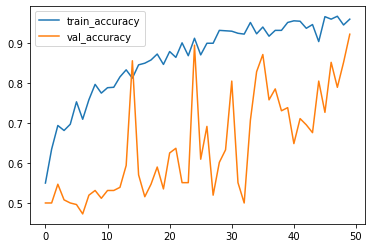

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Step 8 : Evaluate the Model 

### 8.1 - Metrics

In [14]:
from math import ceil

metric_names = model.metrics_names
print ("model metrics : " , metric_names)

metrics = model.evaluate(val_data_gen, batch_size=val_data_gen.batch_size, steps=ceil(val_data_gen.n // val_data_gen.batch_size) )

for idx, metric in enumerate(metric_names):
    print ("Metric : {} = {:,.3f}".format (metric_names[idx], metrics[idx]))

model metrics :  ['loss', 'accuracy']
4/4 [==============================] - 0s 110ms/step - loss: 0.4361 - accuracy: 0.9219
Metric : loss = 0.436
Metric : accuracy = 0.922


### 8.2 - Predictions and Confusion Matrix

In [15]:
import numpy as np
from math import ceil


print ("predicting on {:,} test images".format(val_data_gen.n))
# we need a ceiling for steps
predictions = model.predict(val_data_gen, batch_size=val_data_gen.batch_size, 
                            steps=ceil(val_data_gen.n / val_data_gen.batch_size) )
print( 'predictions.shape: ', predictions.shape)


if train_data_gen.class_mode == 'categorical':
    # converting softmax --> classes
    print ("convering softmax --> classes")
    predictions2 = [ np.argmax(p) for p in predictions]

if train_data_gen.class_mode == 'binary':
    # converting sigmoid --> classes
    print ("converting sigmod --> binary")
    predictions2 = [0 if n < 0.5 else 1 for n in predictions]


# ## Ensure all predictions match
assert(len(predictions) == len(predictions2) == len(val_data_gen.classes) )

predicting on 256 test images
predictions.shape:  (256, 2)
convering softmax --> classes


In [16]:
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

print ('predictions : ' , predictions[:10])
print ('prediction2: ' , predictions2[:10])

predictions :  [[ 1.00  0.00]
 [ 0.00  1.00]
 [ 0.00  1.00]
 [ 1.00  0.00]
 [ 1.00  0.00]
 [ 0.00  1.00]
 [ 1.00  0.00]
 [ 0.00  1.00]
 [ 0.00  1.00]
 [ 0.93  0.07]]
prediction2:  [0, 1, 1, 0, 0, 1, 0, 1, 1, 0]


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_labels = val_data_gen.classes
cm = confusion_matrix(test_labels, predictions2, labels = range(0, NUM_CLASSES))
cm

array([[51, 77],
       [63, 65]])

class index mapping :  {'horses': 0, 'humans': 1}


[]

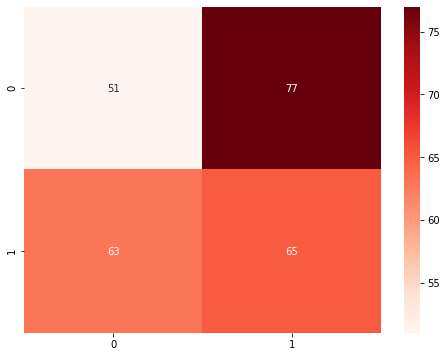

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

print ("class index mapping : ", val_data_gen.class_indices)

plt.figure(figsize = (8,6))

# colormaps : cmap="YlGnBu" , cmap="Greens", cmap="Blues",  cmap="Reds"
sns.heatmap(cm, annot=True, cmap="Reds", fmt='d').plot()

### Overfit
Looking at the learning curves we can see our model is overfitting.  
There are 2 options for us
- Adding Dropout layers
- Using image augmentation


## Step 9 - Adding Dropout

### 9.1 - Modify model

We are going to modify our model by adding Dropout layers.  
Typically, Dropouts layers are added after MaxPool layer.  
Start with one dropout layer and see if that makes a difference in overfitting

Replace code in **Step-4** with the following code


```python

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2,2)),
    Dropout(0.2),  ## <-- adding dropout after maxpooling layer

    ...
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

print(model.summary())
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

```

### 9.2 - Run Again with Dropout layers added

- Select 'Kernel --> Restart Kernel and Run all Cells'
- Notice the training time
- Also observe the learning curve.  Does it look better?
- Do you still detect overfitting?

## Step 10: Adding Image Augmentation

### 10.1 : Modify Training Image Generator

Adding Dropout may have helped a little bit.   
But we still see our model **overfitting** or 'memorizing' training data.  
Let's fix this by introducing small variations to training images.  
This is called **image augmentation**  

In **Step-3** replace **`train_data_generator`** as follows.


```python
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5
                            )
```

### 10.2 - Run Again with Dropout layers + Image Augmentation added

- Select 'Kernel --> Restart Kernel and Run all Cells'
- Notice the training time
- Also observe the learning curve.  Does it look better?
- Do you still detect overfitting?

## Step 11 : Exercise: Evaluate and Improve the Model
See visualizations below!

**TODO: Increase model accuracy (experiment with following approaches)**  
- Switch to a larger dataset in **Step-1**
- Increase the training epochs to 50, 100  in **Step-2**
- Add more layers to the model (you can add Conv+MaxPool layers) and experiment **Step-4**

## Step 12: Visually Inspecting Results

label indices :  {'horses': 0, 'humans': 1}
image directory :  /home/sujee/.keras/datasets/horse-or-human/validation
horses 0
humans 1


<Figure size 432x288 with 0 Axes>

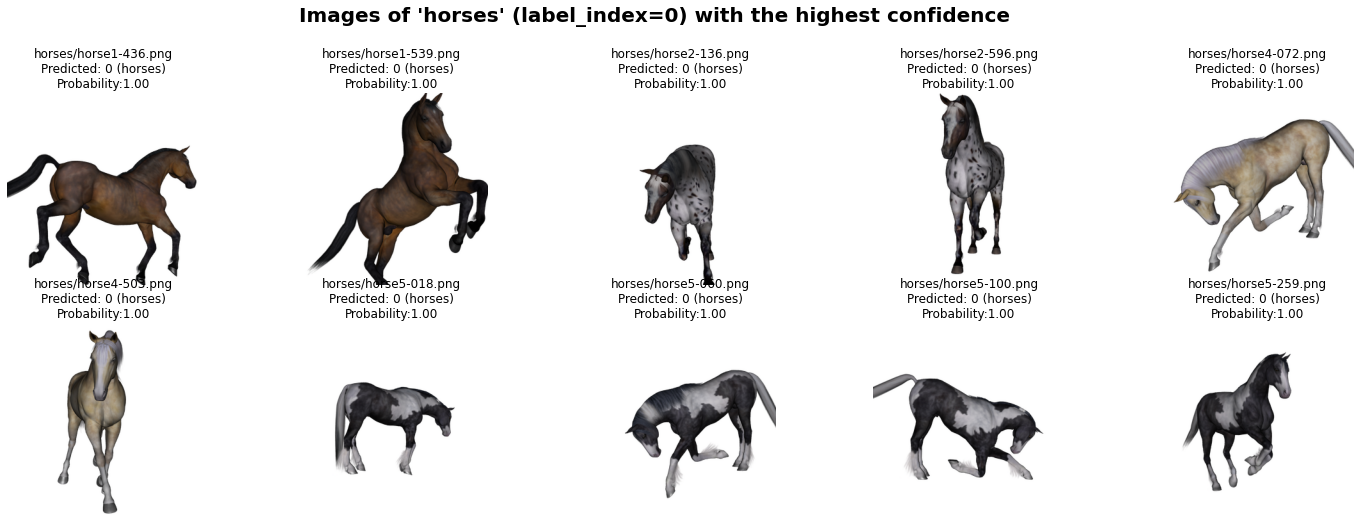

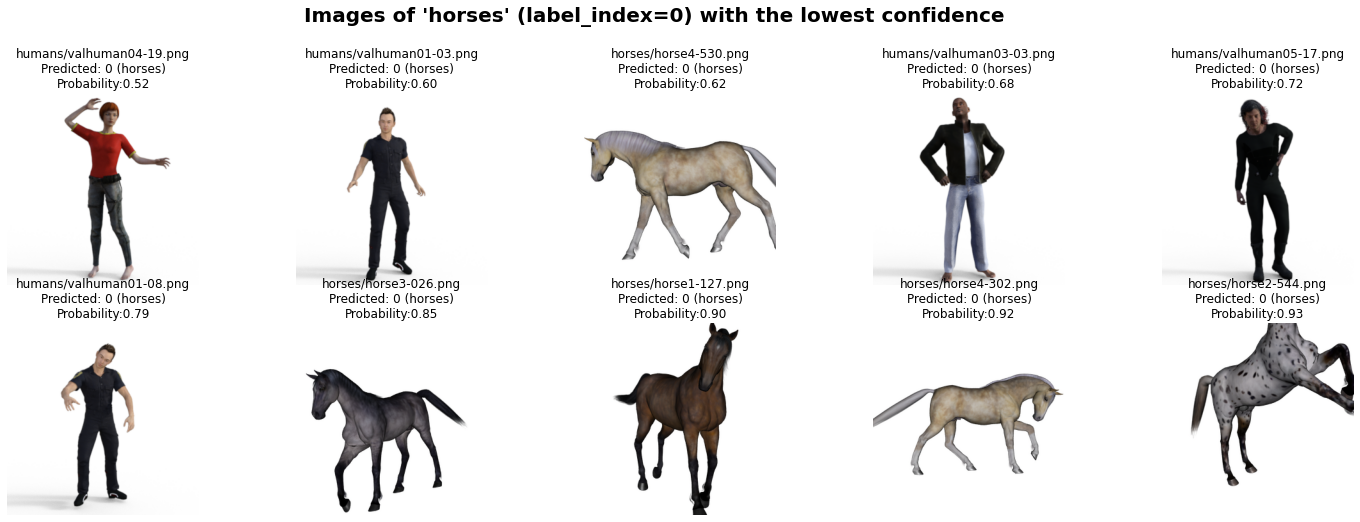

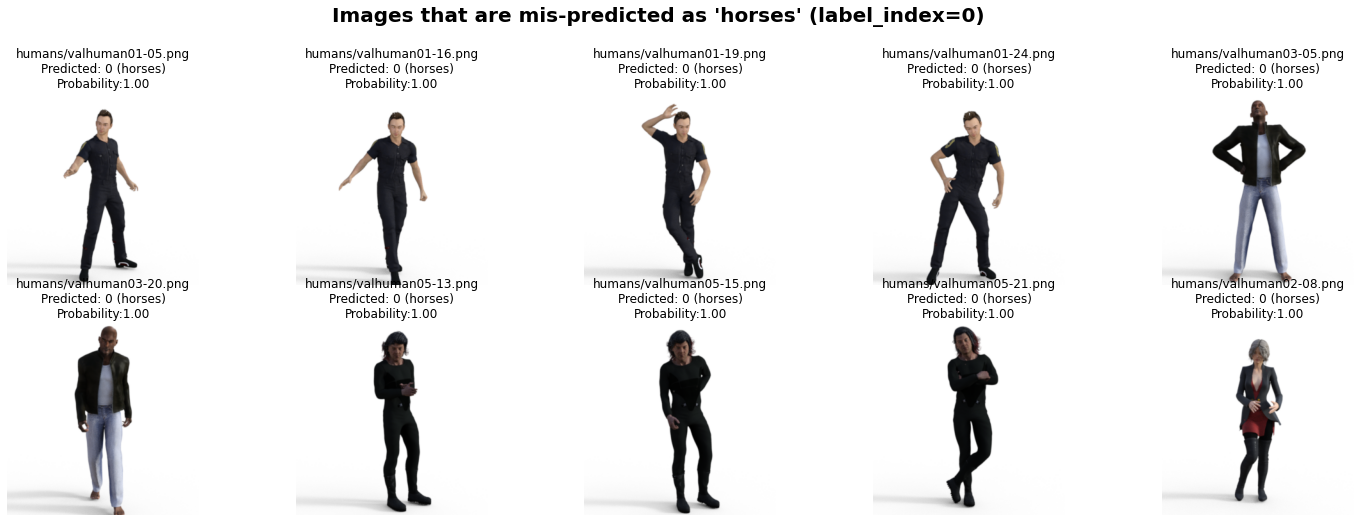

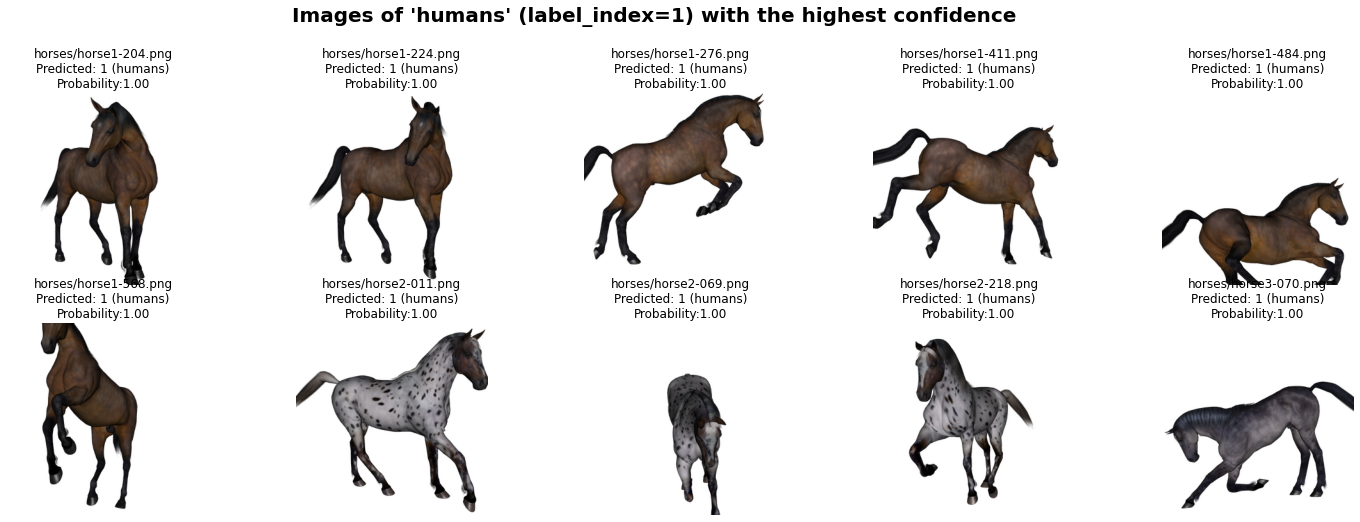

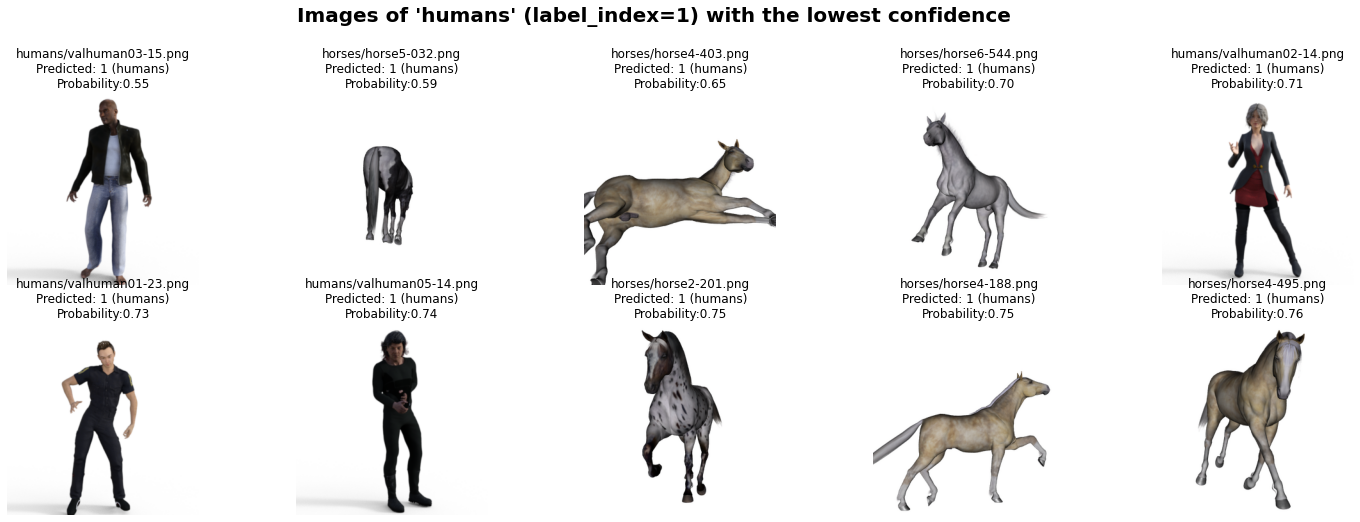

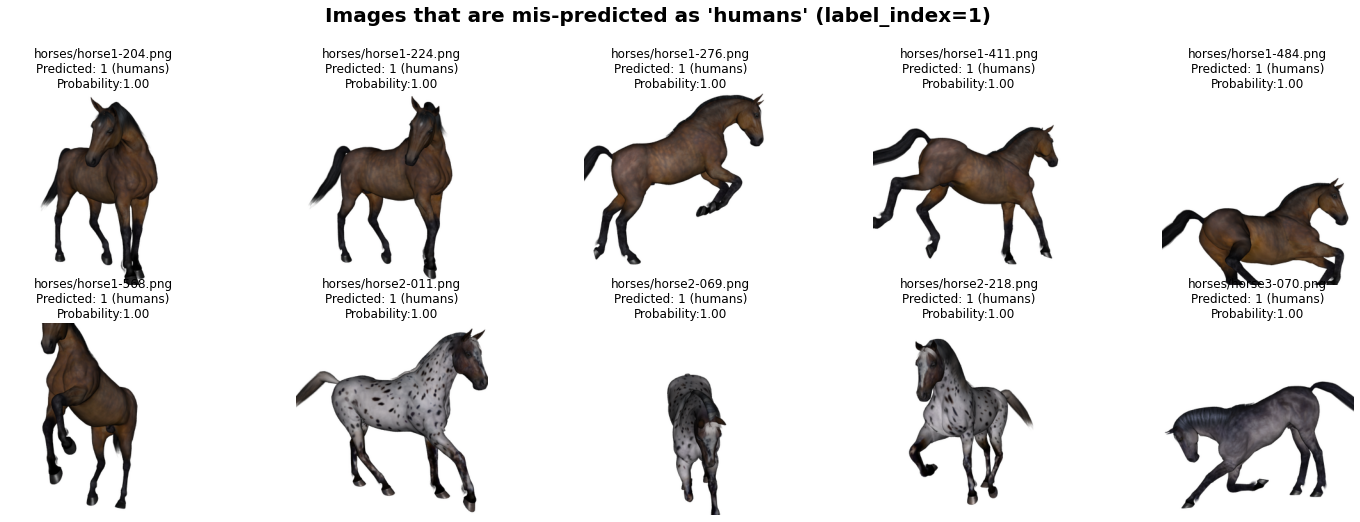

In [19]:
from image_utils import plot_prediction_stats_on_all_classes

val_data_gen.reset() # reset back to batch-1
plot_prediction_stats_on_all_classes(model, val_data_gen)

## Cleanup 
Before running the next exercise, run the following cell to terminate processes and free up resources

In [20]:
## Kill any child processes (like tensorboard)

import psutil
import os, signal

current_process = psutil.Process()
children = current_process.children(recursive=True)
for child in children:
    print('Killing Child pid  {}'.format(child.pid))
    os.kill(child.pid, signal.SIGKILL)
    
## This will kill actual kernel itself
# os.kill(os.getpid(), signal.SIGKILL)

Killing Child pid  5717
